# Step 0. Import libraries

In [1]:
import os
import random
import numpy as np
import tarfile
import sys
import pickle
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.contrib.slim.python.slim.nets import inception_v3
import matplotlib.pyplot as plt
%matplotlib inline

# Step 1. Uncompress the image folder

In [2]:
num_classes = 3
train_filename = 'training-images.tar.gz'

def do_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0] # remove .tar.gz
    if os.path.isdir(root) and not force:
        print('%s already exists. Skipping extracting %s.' % (root, filename))
    else:
        print('Extracting data for %s...' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (num_classes, len(data_folders)))
    print(data_folders)
    return data_folders

train_folders = do_extract(train_filename)

Extracting data for training-images...
['training-images/couches', 'training-images/mattresses', 'training-images/tv-monitor']


In [3]:
def do_remove(folder):
    image_files = os.listdir(folder)
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image = Image.open(image_file)
        except IOError as e:
            os.remove(image_file)
            print('Removed %s' % image_file)

do_remove('training-images/couches')
do_remove('training-images/mattresses')
do_remove('training-images/tv-monitor')

Removed training-images/couches/._10.01.16 GT Route (141).JPG
Removed training-images/couches/._Icon
Removed training-images/couches/Icon
Removed training-images/mattresses/._Icon
Removed training-images/mattresses/Icon
Removed training-images/tv-monitor/._.DS_Store
Removed training-images/tv-monitor/._09.17.16 GT Route (7).JPG
Removed training-images/tv-monitor/._10.01.16 GT Route (131).JPG
Removed training-images/tv-monitor/._17271707-large.jpg
Removed training-images/tv-monitor/._23-samsung-syncmaster-2333t-lcd-widescreen-desktop-display-monitor-d9e99492b3de3675bfc97885a309f5ab.jpg
Removed training-images/tv-monitor/._computer-monitor-in-front-of-a-full-skip-or-dumpster-with-unwanted-achk1e.jpg
Removed training-images/tv-monitor/._discarded-television_fysOVeAd.jpg
Removed training-images/tv-monitor/._Icon
Removed training-images/tv-monitor/._images (1).jpeg
Removed training-images/tv-monitor/._images.jpeg
Removed training-images/tv-monitor/._img_1039.jpg
Removed training-images/tv-m

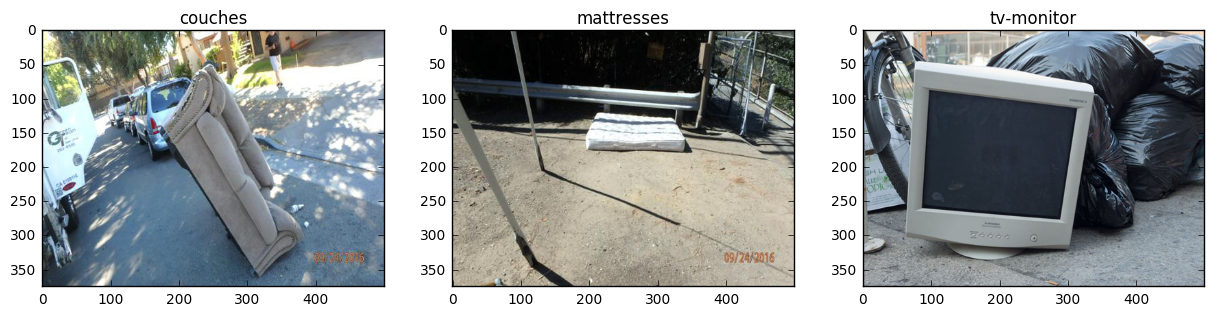

In [4]:
# test to see if uncompressing is done properly
path_1 = 'training-images/couches/'
path_2 = 'training-images/mattresses/'
path_3 = 'training-images/tv-monitor/'

fig = plt.figure(figsize=(15,5))
img_1_name = random.choice([x for x in os.listdir(path_1) if os.path.isfile(os.path.join(path_1, x))])
img_2_name = random.choice([x for x in os.listdir(path_2) if os.path.isfile(os.path.join(path_2, x))])
img_3_name = random.choice([x for x in os.listdir(path_3) if os.path.isfile(os.path.join(path_3, x))])
img_1 = Image.open(os.path.join(path_1,img_1_name))
img_2 = Image.open(os.path.join(path_2,img_2_name))
img_3 = Image.open(os.path.join(path_3,img_3_name))

plt.subplot(131)
plt.imshow(img_1)
plt.title('couches', fontsize=12)

plt.subplot(132)
plt.imshow(img_2)
plt.title('mattresses', fontsize=12)

plt.subplot(133)
plt.imshow(img_3)
plt.title('tv-monitor', fontsize=12)

# Step 2. Create the dataset 

In [5]:
inception_size = inception_v3.inception_v3.default_image_size
image_width, image_height = inception_size, inception_size

def do_load(folder, min_num_images):
    image_count = 0
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_height, image_width, 3), dtype=np.uint8)
    for image in image_files:
        file_name, file_extension = os.path.splitext(image)
        image_file = os.path.join(folder, image)
        try:
            img = Image.open(image_file)
            img = img.resize((image_width, image_height), Image.ANTIALIAS)
            img.save(folder + file_name + '.jpg','JPEG')
            image_data = np.array(img)
            if image_data.shape != (image_height, image_width, 3):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[image_count] = image_data
            image_count += 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '. Skipped reading.')
    
    if image_count < min_num_images:
        raise Exception('Fewer images than expected: %d < %d' %(image_count, min_num_images))
    
    print('Full dataset size:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset), '\n')
    
    return dataset

# Step 3. Pickle the dataset

In [6]:
def do_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        pickle_filename = folder + '.pickle'
        dataset_names.append(pickle_filename)
        if os.path.exists(pickle_filename) and not force:
            print('%s already exists. Skipped pickling.' % pickle_filename)
        else:
            print('Pickling %s...' % pickle_filename)
            dataset = do_load(folder, min_num_images_per_class)
            try:
                with open(pickle_filename, 'wb') as f:
                    pickle.dump(dataset, f)
            except Exception as e:
                print('Unable to save data to ', pickle_filename, ':', e)
    return dataset_names

train_datasets = do_pickle(train_folders, 10)

Pickling training-images/couches.pickle...
Full dataset size: (26, 299, 299, 3)
Mean: 119.150657983
Standard deviation: 64.3811558115 

Pickling training-images/mattresses.pickle...
Full dataset size: (21, 299, 299, 3)
Mean: 105.043578931
Standard deviation: 64.0816744176 

Pickling training-images/tv-monitor.pickle...
Full dataset size: (83, 299, 299, 3)
Mean: 110.517774232
Standard deviation: 65.5571312484 



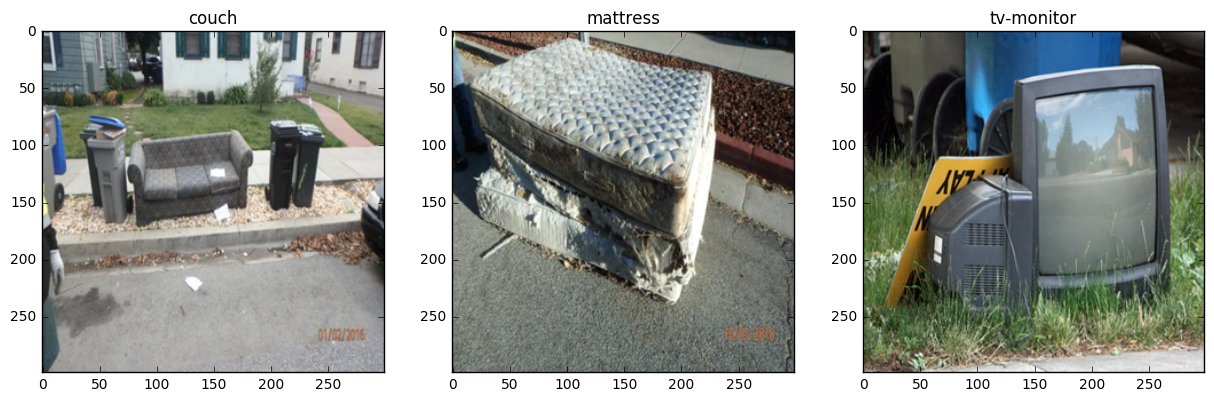

In [7]:
# test to see if pickling the dataset is done properly
path_1p = 'training-images/couches.pickle'
path_2p = 'training-images/mattresses.pickle'
path_3p = 'training-images/tv-monitor.pickle'

with open(path_1p, 'rb') as f1:
    train_1 = pickle.load(f1)
    img_1p = train_1[random.randint(0, len(train_1)-1)]
    del train_1
with open(path_2p, 'rb') as f2:
    train_2 = pickle.load(f2)
    img_2p = train_2[random.randint(0, len(train_2)-1)]
    del train_2
with open(path_3p, 'rb') as f3:
    train_3 = pickle.load(f3)
    img_3p = train_3[random.randint(0, len(train_3)-1)]
    del train_3
    
fig = plt.figure(figsize=(15,5))

plt.subplot(131)
plt.imshow(img_1p)
plt.title('couch', fontsize=12)

plt.subplot(132)
plt.imshow(img_2p)
plt.title('mattress', fontsize=12)

plt.subplot(133)
plt.imshow(img_3p)
plt.title('tv-monitor', fontsize=12)

# Step 4. Merge all datasets

In [8]:
def create_dataset(batch_size, image_height, image_width):
    features = np.ndarray(shape=(batch_size, image_height, image_width, 3), dtype=np.uint8)
    labels = np.ndarray(batch_size, dtype=np.int32)
    return features, labels

def merge_datasets(pickle_files, train_size):
    num_classes, train_offset = len(pickle_files), 0
    train_size_per_class = train_size // num_classes
    train_dataset, train_labels = create_dataset(train_size, image_height, image_width)
    for label, pickle_file in enumerate(pickle_files):  
        try:
            with open(pickle_file, 'rb') as f:
                item_set = pickle.load(f)
                np.random.shuffle(item_set)
                train_item = item_set[:train_size_per_class, :, :]
                del item_set
                train_dataset[train_offset:train_offset+train_size_per_class, :, :] = train_item
                train_labels[train_offset:train_offset+train_size_per_class] = label
                train_offset += train_size_per_class
        except Exception as e:
            print('Unable to process data from ', pickle_file, ':', e)
    return train_dataset, train_labels

train_size = 10
train_features, train_labels = merge_datasets(train_datasets, train_size) 
train_features, train_labels = train_features[:-1], train_labels[:-1] # get rid of the last label
print('Training:', train_features.shape, train_labels.shape)

Training: (9, 299, 299, 3) (9,)


# Step 5. Pickle and create train/val/test datasets

In [9]:
train = {}
train['features'], train['label'] = train_features, train_labels

with open('train.pickle', 'wb') as f4:
    pickle.dump(train, f4, protocol=pickle.HIGHEST_PROTOCOL)
with open('train.pickle', 'rb') as f5:
    data = pickle.load(f5)

X_train, X_test, y_train, y_test = train_test_split(data['features'], data['label'], test_size=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(data['features'], data['label'], test_size=0.2, random_state=0)

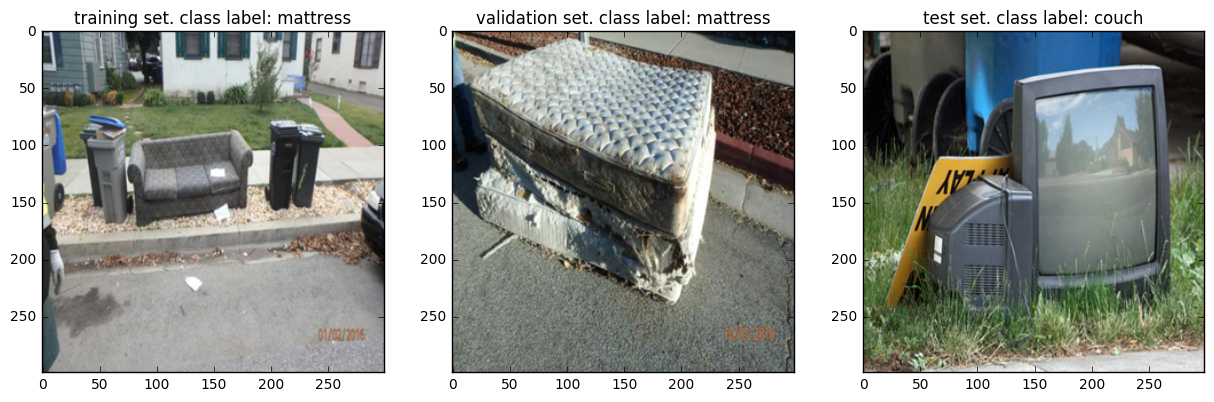

In [10]:
# test to see if the unpickled training/test datasets are right
class_map = {0:'couch', 1:'mattress', 2:'tv-monitor'}
rand_train, rand_val, rand_test = random.randint(0, len(X_train)-1), random.randint(0, len(X_val)-1), random.randint(0, len(X_test)-1)

fig = plt.figure(figsize=(15,5))
img_train, img_val, img_test = X_train[rand_train], X_val[rand_val], X_test[rand_test]

plt.subplot(131)
plt.imshow(img_1p)
plt.title('training set. class label: %s' % class_map[y_train[rand_train]], fontsize=12)

plt.subplot(132)
plt.imshow(img_2p)
plt.title('validation set. class label: %s' % class_map[y_train[rand_val]], fontsize=12)

plt.subplot(133)
plt.imshow(img_3p)
plt.title('test set. class label: %s' % class_map[y_train[rand_test]], fontsize=12)

Credits: 
<ul>
<li>https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/1_notmnist.ipynb</li>
</ul>